# **Working memory training**: preparing tidy dataframes with networks' recruitment and integration values

Karolina Finc | Centre for Modern Interdisciplinary Technologies, Nicolaus Copernicus University in Toruń, Poland

**Last edited:** 04-10-2018

Step 0: Loading libraries
-------------------------------

In [4]:
%matplotlib inline

import sys
sys.path.append("..")
import os

import scipy.io as sio
import numpy as np
from nilearn import plotting 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from fctools import networks, figures

#---- matplotlib settings
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
plt.rcParams['font.family'] = 'Helvetica'

Step 1: Selecting subjects to analysis
--------------------------------------------

In [7]:
top_dir = '/home/finc/Dropbox/Projects/LearningBrain/'
out_dir = f'{top_dir}data/neuroimaging/03-modularity/dynamic/04-recruitment_integration/'

# Selecting subjects which finished the study
groups = pd.read_csv('../data/behavioral/group_assignment.csv')

trained = (groups.group == 'Experimental') | (groups.group == 'Control')
trained_subs = groups[trained]
subs = trained_subs['sub'].values

#--- creating vectors to filter by group
experimental = (trained_subs == 'Experimental')
control = (trained_subs == 'Control')

exp_vector = experimental['group'].values
con_vector = control['group'].values

#--- dualnback - selecting subjects included into dinal analysis and creating group assignment vectors
dualnback_exclude = ['sub-13', 'sub-21', 'sub-23', 'sub-50'] # higly motion subjects in one of four sessions
dual_vector = [True if sub not in dualnback_exclude else False for sub in subs]
exp_vector = exp_vector[dual_vector]
con_vector = con_vector[dual_vector]
subs = trained_subs['sub'][dual_vector].values

n = sum(dual_vector)
print(f'Number of subject after excluding subjects with higly motion: {n}')

Number of subject after excluding subjects with higly motion: 42


Step 3: Getting modules names and color pallete
----------------------------------------

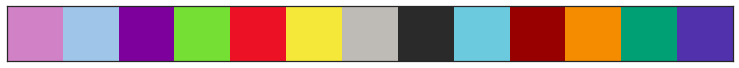

In [9]:
labels = pd.read_csv('../support/modules.txt', sep = " ", header = None)

power_colors_new = {'AU':'#d182c6', 
                'CER':'#9fc5e8', 
                'CO':'#7d009d', 
                'DA':'#75df33', 
                'DM':'#ed1126', 
                'FP':'#f6e838', 
                'MEM':'#bebab5', 
                'SAL':'#2a2a2a', 
                'SOM':'#6ccadf', 
                'SUB':'#980000', 
                'UNC':'#f58c00', 
                'VA':'#00a074', 
                'VIS':'#5131ac',}

modules = sorted(labels[0].values)
network_pal = (sns.color_palette(power_colors_new.values()))
sns.palplot(sns.color_palette(power_colors_new.values()))

network_lut = dict(zip(map(str, np.unique(modules)), network_pal))

network_colors = pd.Series(modules).map(network_lut)
network_colors = np.asarray(network_colors)

n_roi = len(labels)
n_net = len(np.unique(modules))

Step 4: Calculate integration and recruitment for each network
----------------------------------------------------------------

In [10]:
# Load module allegiance matrix
P = np.load(f'{top_dir}data/neuroimaging/03-modularity/dynamic/03-allegiance_matrices/allegiance_matrix_power_dualnback_opt_mean.npy')

# Calculate recruitment/integration grouped by distnct networks
NA = networks.fc_cartography_4d(P, modules)
NA.shape

(46, 4, 13, 13)

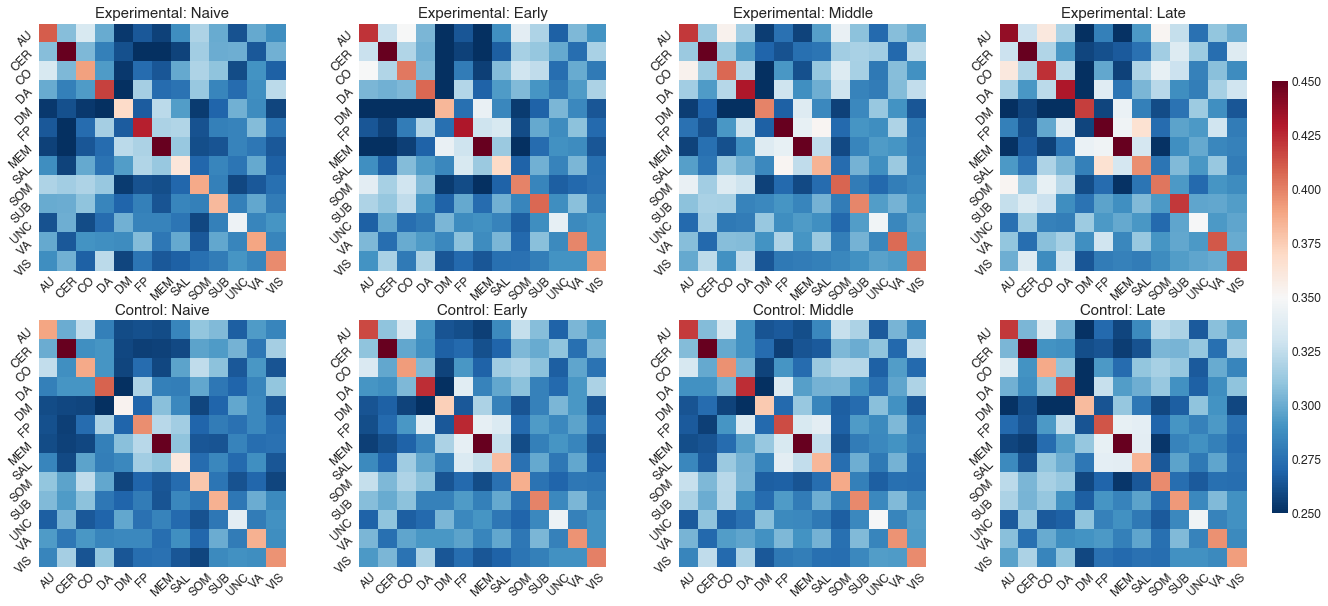

In [21]:
# Plotting mean allegiances grouped by distinct networks
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)  
plt.rc('axes', linewidth=0)

fig, axes = plt.subplots(2, 4)
fig.set_size_inches(22, 10)
group_vectors = [exp_vector, con_vector]
ses_lab = ['Naive', 'Early', 'Middle', 'Late']
group_lab = ['Experimental', 'Control']

NA_clean = NA[dual_vector, :, :] # remove highly motion subjects

for i, vec in enumerate(group_vectors):
    for j, ses in enumerate(ses_lab):
        M = NA_clean[vec,j, :,:].mean(axis=0)
        plt.ioff()
        g = sns.heatmap(M, yticklabels = np.unique(modules), 
                        xticklabels = np.unique(modules), 
                        square = True, 
                        cmap = "RdBu_r", 
                        ax=axes[i][j],
                        vmin = 0.25, vmax = 0.45,
                        cbar=None)
        g.set_title(f'{group_lab[i]}: {ses}', size = 15)
        g.set_xticklabels(np.unique(modules), rotation=45)
        g.set_yticklabels(np.unique(modules), rotation=45)

im = plt.gca().get_children()[0]
cax = fig.add_axes([.91, .2, .01, .6]) 
fig.colorbar(im, cax=cax, drawedges = False)


Step 5: Create tidy dataframe with integration and recruitment values
----------------------------------------

In [14]:
result = pd.DataFrame()
ses_lab = ['Naive', 'Early', 'Middle', 'Late']
group = trained_subs.values[:,1]

integ = pd.DataFrame()
result = pd.DataFrame()

for k, net1 in enumerate(np.unique(modules)):
    for l, net2 in enumerate(np.unique(modules)):
        for i, sub in enumerate(subs):
            for j, ses in enumerate(ses_lab):
                net_integ = NA[i, j, k, l]
                result_pre = pd.DataFrame([[sub, ses, net2, net_integ]], columns=['Subject', 'Session', 'Network', f'{net1}'])               
                result = result.append(result_pre) 
    if k == 0:
        integ = result
        result = pd.DataFrame()
    if k > 0:
        integ = pd.merge(integ, result, on = ['Subject', 'Session', 'Network'])
        result = pd.DataFrame()
        
trained_subs = trained_subs.rename(index=str, columns={"group": "Group", "sub": "Subject"})
integration_tidy = pd.merge(trained_subs, integ, on="Subject")
integration_tidy.to_csv(f'{out_dir}Power_integration_recruitment_all_networks_new.csv', index=False)


integration_tidy.head()

,Subject,Group,Session,Network,AU,CER,CO,DA,DM,FP,MEM,SAL,SOM,SUB,UNC,VA,VIS
0,sub-01,Control,Naive,AU,0.368444,0.242635,0.300036,0.249483,0.251251,0.256768,0.261477,0.273778,0.296924,0.299695,0.254772,0.280902,0.261282
1,sub-01,Control,Early,AU,0.410479,0.243173,0.315819,0.296622,0.265587,0.275328,0.276000,0.280205,0.300226,0.310482,0.234920,0.281543,0.276335
2,sub-01,Control,Middle,AU,0.466953,0.341144,0.326294,0.324490,0.275962,0.293272,0.318185,0.277650,0.351426,0.377349,0.269852,0.333090,0.302392
3,sub-01,Control,Late,AU,0.412521,0.311173,0.317014,0.313301,0.258850,0.257662,0.251285,0.277754,0.324680,0.311491,0.267444,0.314184,0.307989
4,sub-01,Control,Naive,CER,0.242635,0.557125,0.252063,0.282341,0.272345,0.235905,0.243600,0.226201,0.306339,0.268577,0.290955,0.275333,0.301419


Step 5: Create tidy dataframe with integration and recruitment values (for each window)
----------------------------------------

In [11]:
W = np.load(f'{top_dir}data/neuroimaging/03-modularity/dynamic/03-allegiance_matrices/window_allegiance_matrix_power_dualnback.npy')
W.shape

(46, 4, 20, 264, 264)

In [6]:
n_sub = len(W[:, 0, 0, 0, 0])
n_ses = len(W[0, :, 0, 0, 0])
n_nod = len(W[0, 0, 0, :, 0])
n_win = len(W[0, 0, :, 0, 0])

n_net = len(np.unique(modules))
D = np.zeros((n_sub, n_ses, n_win, n_net, n_net))

for i in range(n_sub):
    print(f'Subject {i+1}')
    for j in range(n_ses):
        for k in range(n_win):
            D[i, j, k, :, :] = networks.fc_cartography(W[i,j,k,:,:], modules)

Subject 1
Subject 2
Subject 3
Subject 4
Subject 5
Subject 6
Subject 7
Subject 8
Subject 9
Subject 10
Subject 11
Subject 12
Subject 13
Subject 14
Subject 15
Subject 16
Subject 17
Subject 18
Subject 19
Subject 20
Subject 21
Subject 22
Subject 23
Subject 24
Subject 25
Subject 26
Subject 27
Subject 28
Subject 29
Subject 30
Subject 31
Subject 32
Subject 33
Subject 34
Subject 35
Subject 36
Subject 37
Subject 38
Subject 39
Subject 40
Subject 41
Subject 42
Subject 43
Subject 44
Subject 45
Subject 46


In [7]:
integ = pd.DataFrame()
result = pd.DataFrame()
windows = np.arange(1,21)

subs = trained_subs.values[:,0]
group = trained_subs.values[:,1]

ses_lab = ['Naive', 'Early', 'Middle', 'Late']

for k, net1 in enumerate(np.unique(modules)):
    print(f'{net1}')
    for l, net2 in enumerate(np.unique(modules)):
        for w, win in enumerate(windows): 
            for i, sub in enumerate(subs):
                for j, ses in enumerate(ses_lab):
                    net_integ = D[i, j, w, k, l]
                    result_pre = pd.DataFrame([[sub, group[i], ses, win, net2, net_integ]], 
                                              columns=['Subject', 'Group', 'Session', 'Window', 'Network', f'{net1}'])               
                    result = result.append(result_pre) 
    if k == 0:
        integ = result
        result = pd.DataFrame()
    if k > 0:
        integ = pd.merge(integ, result, on = ['Subject', 'Group', 'Session', 'Network', 'Window'])
        result = pd.DataFrame()
        
integ.to_csv(f'{out_dir}Power_integration_recruitment_windows_all_networks.csv', index=False)

AU
CER
CO
DA
DM
FP
MEM
SAL
SOM
SUB
UNC
VA
VIS
